# Temporal and Spatial Dependencies
This notebook explores temporal and spatial dependancies within the data
in a new md files for each of the files in 2_exploratory_data_analysis, List the 3–8 key variables this notebook produces, as well as the functions and plots


This notebook loads the baseline files, creates histograms of the intensities, calculates and plots descriptive stats and the frame to frame differences

Author: Brynn Harris-Shanks

## Set-up
### Imports

In [11]:
from pathlib import Path
import os
import sys
import yaml

# Locate repo root
repo_root = next(
    p for p in (Path.cwd(), *Path.cwd().parents)
    if (p / "config" / "config.yml").exists()
)

# Add code directory to import path
code_dir = repo_root / "code"
if str(code_dir) not in sys.path:
    sys.path.insert(0, str(code_dir))

# Load config
config_path = repo_root / "config" / "config.yml"
config = yaml.safe_load(config_path.read_text(encoding="utf-8"))

In [12]:
import matplotlib
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython import get_ipython
import numpy as np
import pandas as pd
from utils import helper_functions as hf
from utils import autocorrelation as acf
from matplotlib import cm

In [13]:
# Inline backend
USE_WIDGET = False
ipy = get_ipython()
backend_mode = "inline"
if ipy is not None:
    try:
        ipy.run_line_magic("matplotlib", "inline")
    except Exception:
        pass
print(f"Matplotlib backend: {matplotlib.get_backend()} | mode={backend_mode}")

# Core paths
deriv_root = repo_root / config["paths"]["preprocessing"]
subjects = config["subjects"]["all"]
sample_subject = config["subjects"]["default"]
data_mode = "zscore"
sample_session_idx = 2
sample_frame_idx = 0

Matplotlib backend: inline | mode=inline


In [14]:
# Specific to this notebook
eda_cfg = config["eda"]
eda_root_name = eda_cfg["root_name"]
analysis_modes = eda_cfg["analysis_modes"]
acf_qc_filename = eda_cfg["acf_qc_filename"]

fdiff_robust_pctl = tuple(float(x) for x in eda_cfg["frame_diff_robust_percentiles"])
spatial_eps = float(eda_cfg["spatial_eps"])
spatial_min_valid_samples = int(eda_cfg["spatial_min_valid_samples"])

# Parameters for temporal and spatial dependency analyses
ACF_MAX_LAG = 500
PSD_NPERSEG = 256
DEFAULT_FS_HZ = 1.0
AUTOCORR_ROOT_SUBDIR = "autocorr_psd"
SPATIAL_ROOT_SUBDIR = "spatial_autocorr"
SPATIAL_NEIGHBORHOODS = (4, 8)

ACF_REQUIRE_QC = True
SPATIAL_REQUIRE_QC = ACF_REQUIRE_QC
RADIAL_N_BINS = 40
SHUFFLE_KIND = "circular_shift"  # "circular_shift" or "time_shuffle"
SHUFFLE_SEED = 42

SEED_ROOT_SUBDIR = "seed_corr"
SEED_CENTER = (49, 21)  # global (y, x) seed for all subjects/sessions
SEED_PATCH_RADIUS = 8  # 0=pixel, >0=square patch radius
SEED_EPS = spatial_eps
SEED_MIN_VALID_SAMPLES = spatial_min_valid_samples


---
### Load subjects 

In [15]:
def _ensure_acf_configured():
    acf.configure(
        deriv_root_path=deriv_root,
        eda_root_name=eda_root_name,
        acf_qc_filename=acf_qc_filename,
        frame_diff_robust_pctl=fdiff_robust_pctl,
        spatial_eps=spatial_eps,
        spatial_min_valid_samples=spatial_min_valid_samples,
    )


_ensure_acf_configured()


---
### Load Baseline Data

Load baseline sessions for model training.

In [16]:
for subject in subjects:
    data_output_dir = deriv_root / subject  # subject-specific output folder
    data_output_dir.mkdir(parents=True, exist_ok=True)
    if data_mode == "raw":
        baseline_output_dir = os.path.join(data_output_dir, "baseline_only")
    else:
        baseline_output_dir = os.path.join(
            data_output_dir, f"baseline_only_standardized/{data_mode}"
        )
    # Load all baseline sessions
    baseline_sessions = hf.load_saved_baseline_sessions(baseline_output_dir)

    # Print summary
    if len(baseline_sessions) > 0:
        print(f"\nBaseline Data Summary:{subject} ({data_mode})")
        print(f"  Total sessions: {len(baseline_sessions)}")
        total_frames = sum(s["frames"].shape[0] for s in baseline_sessions)
        print(f"  Total baseline frames: {total_frames:,}")

        spatial_shapes = [s["frames"].shape[1:] for s in baseline_sessions]
        unique_shapes = set(spatial_shapes)
        print(f"  Spatial dimensions: {unique_shapes}")

        # Show frame count distribution
        frame_counts = [s["frames"].shape[0] for s in baseline_sessions]
        print(
            f"  Frames per session: min={min(frame_counts)}, max={max(frame_counts)}, "
            f"mean={np.mean(frame_counts):.0f}, std={np.std(frame_counts):.0f}"
        )

        # first session
        if len(baseline_sessions) > 0:
            first_session = baseline_sessions[0]
            print(f"\n  First session ({first_session['session_id']}):")
            print(f"    Frames: {first_session['frames'].shape[0]}")
            print(f"    Shape: {first_session['frames'].shape}")
            print(f"    Dtype: {first_session['frames'].dtype}")
            print(
                f"Value range: [{first_session['frames'].min():.2f}, {first_session['frames'].max():.2f}]"
            )


Baseline Data Summary:secundo (zscore)
  Total sessions: 34
  Total baseline frames: 14,043
  Spatial dimensions: {(107, 128), (132, 128), (101, 128), (112, 128), (96, 128), (91, 128), (122, 128)}
  Frames per session: min=1, max=906, mean=413, std=202

  First session (Se01072020):
    Frames: 526
    Shape: (526, 101, 128)
    Dtype: float32
Value range: [-4.49, 10.65]

Baseline Data Summary:gus (zscore)
  Total sessions: 13
  Total baseline frames: 5,838
  Spatial dimensions: {(132, 128), (101, 128), (112, 128), (96, 128), (81, 128), (122, 128)}
  Frames per session: min=258, max=549, mean=449, std=123

  First session (Gu03092020):
    Frames: 539
    Shape: (539, 112, 128)
    Dtype: float32
Value range: [-4.97, 11.45]


---
## Exploratory data analysis

---

### Temporal Autocorrelation 

Loaded 34 baseline sessions
\n[secundo] ACF per/across acquisitions | sessions=34


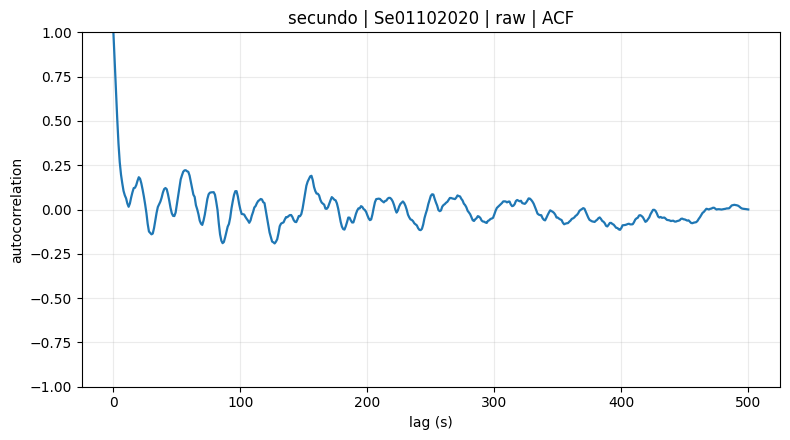

  - skip ACF Se27072020 | raw: failed preprocessing QC: too_short_or_nan_only
  - skip ACF Se31012020 | raw: failed preprocessing QC: too_short_or_nan_only


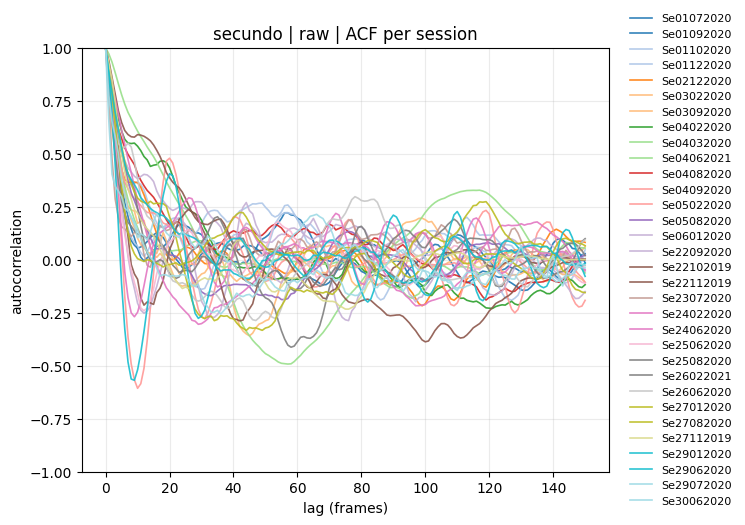

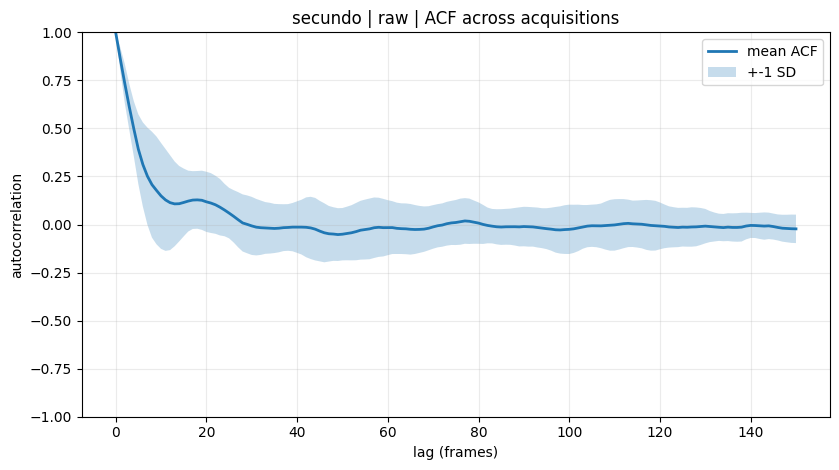

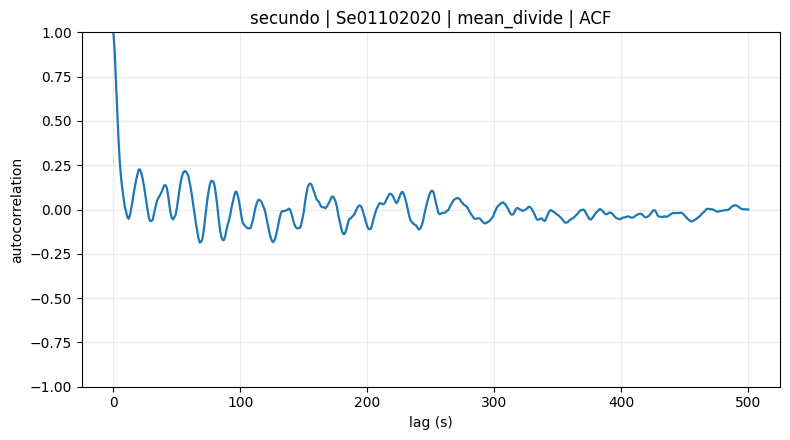

  - skip ACF Se27072020 | mean_divide: failed preprocessing QC: too_short_or_nan_only
  - skip ACF Se31012020 | mean_divide: failed preprocessing QC: too_short_or_nan_only


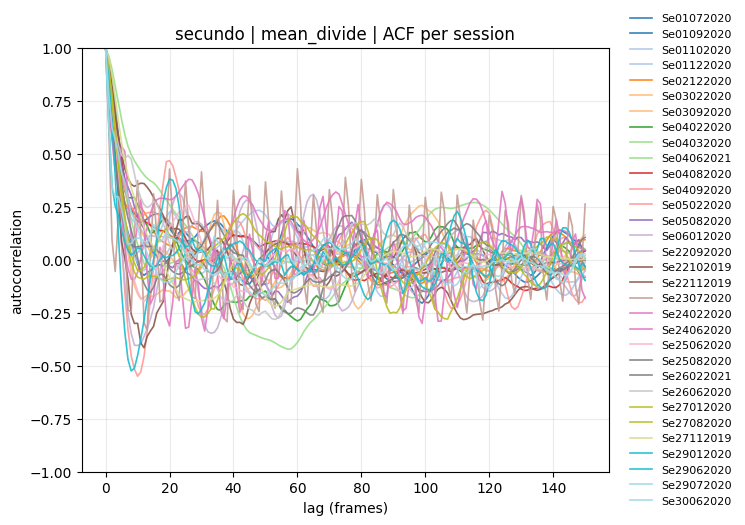

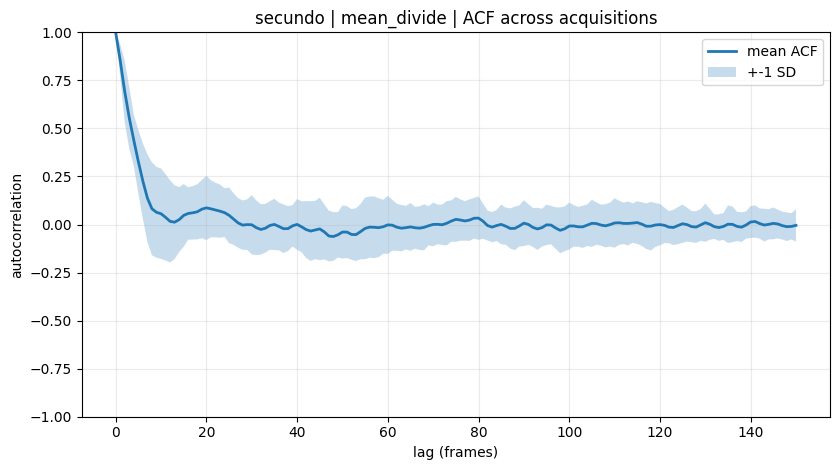

Saved ACF outputs to: c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\eda\autocorr_psd\acf
Loaded 13 baseline sessions
\n[gus] ACF per/across acquisitions | sessions=13
Saved ACF outputs to: c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus\eda\autocorr_psd\acf


In [17]:
# Global-signal analyses deliberately exclude zscore.
GLOBAL_SIGNAL_MODES = [m for m in ["raw", "mean_divide"] if m in analysis_modes]
if len(GLOBAL_SIGNAL_MODES) == 0 and len(analysis_modes) > 0:
    GLOBAL_SIGNAL_MODES = [analysis_modes[0]]



if "sample_subject" not in globals():
    sample_subject = subjects[0]
if "sample_session_idx" not in globals():
    sample_session_idx = 0

# Backward-compatible aliases for downstream cells
_load_acf_qc_map_for_subject = acf.load_acf_qc_map_for_subject
_acf_qc_allows_session = acf.acf_qc_allows_session
_session_global_signal = acf.session_global_signal

if "_ensure_acf_configured" in globals():
    _ensure_acf_configured()
else:
    acf.configure(deriv_root_path=deriv_root)

for subject in subjects:
    baseline_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_dir))
    print(
        f"\\n[{subject}] ACF per/across acquisitions | sessions={len(baseline_sessions)}"
    )
    if len(baseline_sessions) == 0:
        continue

    qc_map = acf.load_acf_qc_map_for_subject(subject)

    out_root = acf.analysis_subject_root(subject, AUTOCORR_ROOT_SUBDIR) / "acf"
    out_per = out_root / "per_session"
    out_across = out_root / "across_sessions"
    out_per.mkdir(parents=True, exist_ok=True)
    out_across.mkdir(parents=True, exist_ok=True)

    for mode in GLOBAL_SIGNAL_MODES:
        acf_series = []
        acf_session_ids = []
        acf_lag_max = None
        skipped = []

        for s_idx, session in enumerate(baseline_sessions):
            session_id = session["session_id"]

            allow_session, qc_reason = acf.acf_qc_allows_session(
                qc_map,
                session_id,
                mode,
                require_qc=ACF_REQUIRE_QC,
            )
            if not allow_session:
                msg = f"failed preprocessing QC: {qc_reason}"
                print(f"  - skip ACF {session_id} | {mode}: {msg}")
                skipped.append((session_id, msg))
                pd.DataFrame(
                    [
                        {
                            "subject": subject,
                            "session_id": session_id,
                            "mode": mode,
                            "status": "skipped_qc",
                            "reason": msg,
                        }
                    ]
                ).to_csv(
                    out_per / f"{subject}_{session_id}_{mode}_acf.csv", index=False
                )
                continue

            try:
                arr, metadata, _ = acf.load_saved_session_bundle(
                    deriv_root, subject, session_id, mode
                )
                x = acf.session_global_signal(arr)
                if x is None:
                    raise ValueError(
                        "invalid global signal (too short / NaN-only / near-constant)"
                    )

                lags, acf_values = acf.standardized_acf(x, ACF_MAX_LAG)
                if acf_values is None:
                    raise ValueError("failed to compute ACF")

                if acf_lag_max is None:
                    acf_lag_max = int(lags[-1])
                else:
                    acf_lag_max = min(acf_lag_max, int(lags[-1]))

                fps = DEFAULT_FS_HZ
                if "source_fps" in metadata:
                    try:
                        fps_meta = float(np.asarray(metadata["source_fps"]).item())
                        if np.isfinite(fps_meta) and fps_meta > 0:
                            fps = fps_meta
                    except Exception:
                        pass

                t_lag_s = lags.astype(np.float64) / float(fps)

                fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
                ax.plot(t_lag_s, acf_values, lw=1.6)
                ax.set_title(f"{subject} | {session_id} | {mode} | ACF")
                ax.set_xlabel("lag (s)")
                ax.set_ylabel("autocorrelation")
                ax.set_ylim(-1.0, 1.0)
                ax.grid(alpha=0.25)
                fig.tight_layout()
                fig.savefig(out_per / f"{subject}_{session_id}_{mode}_acf.png", dpi=180)

                if subject == sample_subject and s_idx == sample_session_idx:
                    plt.show()
                else:
                    plt.close(fig)

                df = pd.DataFrame(
                    {
                        "subject": subject,
                        "session_id": session_id,
                        "mode": mode,
                        "lag": lags.astype(int),
                        "lag_seconds": t_lag_s,
                        "acf": acf_values.astype(np.float64),
                        "source_fps": float(fps),
                        "n_frames": int(arr.shape[0]),
                        "n_signal_samples": int(x.size),
                        "status": "ok",
                    }
                )
                df.to_csv(
                    out_per / f"{subject}_{session_id}_{mode}_acf.csv", index=False
                )

                acf_series.append(acf_values)
                acf_session_ids.append(session_id)
            except Exception as e:
                msg = str(e)
                print(f"  - skip ACF {session_id} | {mode}: {msg}")
                skipped.append((session_id, msg))
                pd.DataFrame(
                    [
                        {
                            "subject": subject,
                            "session_id": session_id,
                            "mode": mode,
                            "status": "skipped",
                            "reason": msg,
                        }
                    ]
                ).to_csv(
                    out_per / f"{subject}_{session_id}_{mode}_acf.csv", index=False
                )

        if len(acf_series) == 0:
            pd.DataFrame(
                [
                    {
                        "subject": subject,
                        "mode": mode,
                        "status": "no_valid_sessions",
                        "n_sessions_total": int(len(baseline_sessions)),
                        "n_sessions_used": 0,
                        "n_sessions_skipped": int(len(skipped)),
                    }
                ]
            ).to_csv(
                out_across / f"{subject}_{mode}_acf_across_summary.csv", index=False
            )
            continue

        L = int(acf_lag_max)
        A = np.stack([s[: L + 1] for s in acf_series], axis=0)

        acf_mean = np.asarray(np.nanmean(A, axis=0), dtype=np.float64).reshape(-1)
        acf_std = np.asarray(np.nanstd(A, axis=0), dtype=np.float64).reshape(-1)
        lags_common = np.arange(L + 1, dtype=np.int32).reshape(-1)

        common_len = int(min(lags_common.size, acf_mean.size, acf_std.size))
        lags_common = lags_common[:common_len]
        acf_mean = acf_mean[:common_len]
        acf_std = acf_std[:common_len]
        A_common = A[:, :common_len]

        # Plot all per-session ACF curves (different color per session).
        fig_all, ax_all = plt.subplots(1, 1, figsize=(9.5, 5.4))
        session_colors = plt.cm.tab20(np.linspace(0, 1, max(2, A_common.shape[0])))
        for i in range(A_common.shape[0]):
            sid = (
                str(acf_session_ids[i]) if i < len(acf_session_ids) else f"session_{i}"
            )
            ax_all.plot(
                lags_common,
                A_common[i],
                color=session_colors[i % len(session_colors)],
                lw=1.2,
                alpha=0.9,
                label=sid,
            )
        ax_all.set_title(f"{subject} | {mode} | ACF per session")
        ax_all.set_xlabel("lag (frames)")
        ax_all.set_ylabel("autocorrelation")
        ax_all.set_ylim(-1.0, 1.0)
        ax_all.grid(alpha=0.25)
        ax_all.legend(
            loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=8, frameon=False
        )
        fig_all.tight_layout(rect=[0, 0, 0.8, 1])
        fig_all.savefig(out_across / f"{subject}_{mode}_acf_all_sessions.png", dpi=180)

        if subject == sample_subject:
            plt.show()
        else:
            plt.close(fig_all)

        fig, ax = plt.subplots(1, 1, figsize=(8.5, 4.8))
        ax.plot(lags_common, acf_mean, lw=2.0, label="mean ACF")
        ax.fill_between(
            lags_common,
            acf_mean - acf_std,
            acf_mean + acf_std,
            alpha=0.25,
            label="+-1 SD",
        )
        ax.set_title(f"{subject} | {mode} | ACF across acquisitions")
        ax.set_xlabel("lag (frames)")
        ax.set_ylabel("autocorrelation")
        ax.set_ylim(-1.0, 1.0)
        ax.grid(alpha=0.25)
        ax.legend(loc="best")
        fig.tight_layout()
        fig.savefig(out_across / f"{subject}_{mode}_acf_across.png", dpi=180)

        if subject == sample_subject:
            plt.show()
        else:
            plt.close(fig)

        pd.DataFrame(
            {
                "subject": subject,
                "mode": mode,
                "lag": lags_common.astype(int),
                "acf_mean": acf_mean.astype(np.float64),
                "acf_std": acf_std.astype(np.float64),
                "n_sessions_used": int(A.shape[0]),
            }
        ).to_csv(out_across / f"{subject}_{mode}_acf_across_curve.csv", index=False)

        pd.DataFrame(
            [
                {
                    "subject": subject,
                    "mode": mode,
                    "status": "ok",
                    "n_sessions_total": int(len(baseline_sessions)),
                    "n_sessions_used": int(A.shape[0]),
                    "n_sessions_skipped": int(len(skipped)),
                    "max_lag_used": int(L),
                    "used_session_ids": "|".join(str(s) for s in acf_session_ids),
                }
            ]
        ).to_csv(out_across / f"{subject}_{mode}_acf_across_summary.csv", index=False)

    print(f"Saved ACF outputs to: {out_root}")


### Spatial Autocorrelation 

In [18]:
# if "_ensure_acf_configured" in globals():
#     _ensure_acf_configured()
# else:
#     acf.configure(deriv_root_path=deriv_root)

# # Spatial ACF across-session harmonization best practice:
# # 1) compute per-session spatial ACF map
# # 2) register each session to a subject template (translation)
# # 3) aggregate on a common canvas with NaN-aware statistics


# def _center_on_canvas(arr2d, canvas_shape, fill=np.nan):
#     arr = np.asarray(arr2d, dtype=np.float32)
#     H, W = canvas_shape
#     h, w = arr.shape
#     out = np.full((H, W), fill, dtype=np.float32)
#     y0 = (H - h) // 2
#     x0 = (W - w) // 2
#     out[y0 : y0 + h, x0 : x0 + w] = arr
#     return out


# def _shift_2d_int(arr2d, shift_y, shift_x, fill=np.nan):
#     a = np.asarray(arr2d, dtype=np.float32)
#     H, W = a.shape
#     out = np.full((H, W), fill, dtype=np.float32)

#     src_y0 = max(0, -int(shift_y))
#     src_y1 = min(H, H - int(shift_y))
#     src_x0 = max(0, -int(shift_x))
#     src_x1 = min(W, W - int(shift_x))

#     if (src_y1 <= src_y0) or (src_x1 <= src_x0):
#         return out

#     dst_y0 = max(0, int(shift_y))
#     dst_x0 = max(0, int(shift_x))
#     dst_y1 = dst_y0 + (src_y1 - src_y0)
#     dst_x1 = dst_x0 + (src_x1 - src_x0)

#     out[dst_y0:dst_y1, dst_x0:dst_x1] = a[src_y0:src_y1, src_x0:src_x1]
#     return out


# def _corr_score(a, b, min_overlap=500):
#     aa = np.asarray(a, dtype=np.float32)
#     bb = np.asarray(b, dtype=np.float32)
#     mask = np.isfinite(aa) & np.isfinite(bb)
#     n = int(mask.sum())
#     if n < int(min_overlap):
#         return -np.inf, n

#     x = aa[mask].astype(np.float64)
#     y = bb[mask].astype(np.float64)
#     x -= np.mean(x)
#     y -= np.mean(y)
#     denom = np.sqrt(np.sum(x * x) * np.sum(y * y))
#     if (not np.isfinite(denom)) or (denom <= 1e-12):
#         return -np.inf, n
#     return float(np.sum(x * y) / denom), n


# def _estimate_translation_phase(template_img, moving_img, min_overlap=500):
#     t = np.asarray(template_img, dtype=np.float32)
#     m = np.asarray(moving_img, dtype=np.float32)

#     mask = np.isfinite(t) & np.isfinite(m)
#     overlap = int(mask.sum())
#     if overlap < int(min_overlap):
#         return 0, 0, np.nan, "low_overlap"

#     t0 = np.where(mask, t, 0.0)
#     m0 = np.where(mask, m, 0.0)

#     tm = float(np.mean(t0[mask])) if overlap > 0 else 0.0
#     mm = float(np.mean(m0[mask])) if overlap > 0 else 0.0
#     t0 = np.where(mask, t0 - tm, 0.0).astype(np.float32)
#     m0 = np.where(mask, m0 - mm, 0.0).astype(np.float32)

#     try:
#         (dx, dy), response = cv2.phaseCorrelate(t0, m0)
#     except Exception:
#         return 0, 0, np.nan, "phasecorr_failed"

#     dx_i = int(np.rint(dx))
#     dy_i = int(np.rint(dy))

#     cand = [
#         (dy_i, dx_i, "phase"),
#         (-dy_i, -dx_i, "phase_neg"),
#         (0, 0, "zero"),
#     ]

#     best = (0, 0, "zero")
#     best_score = -np.inf
#     for cy, cx, ctag in cand:
#         shifted = _shift_2d_int(m, cy, cx, fill=np.nan)
#         s, _ = _corr_score(t, shifted, min_overlap=min_overlap)
#         if s > best_score:
#             best_score = s
#             best = (cy, cx, ctag)

#     by, bx, tag = best
#     return int(by), int(bx), float(response) if np.isfinite(response) else np.nan, tag


# SPATIAL_ALIGN_REF_MODE = "raw"
# SPATIAL_ALIGN_REF_STAT = "mean"
# SPATIAL_ALIGN_MAX_SHIFT_FRAC = 0.20
# SPATIAL_ALIGN_MIN_SCORE = 0.20

# for subject in subjects:
#     baseline_dir = deriv_root / subject / "baseline_only"
#     baseline_sessions = hf.load_all_baseline(str(baseline_dir))
#     print(
#         f"\\n[{subject}] spatial autocorrelation per/across sessions | sessions={len(baseline_sessions)}"
#     )
#     if len(baseline_sessions) == 0:
#         continue

#     qc_map = acf.load_acf_qc_map_for_subject(subject)

#     out_root = (
#         acf.analysis_subject_root(subject, AUTOCORR_ROOT_SUBDIR) / SPATIAL_ROOT_SUBDIR
#     )
#     out_per = out_root / "per_session"
#     out_across = out_root / "across_sessions"
#     out_per.mkdir(parents=True, exist_ok=True)
#     out_across.mkdir(parents=True, exist_ok=True)

#     alignment_cache = {int(n): {} for n in SPATIAL_NEIGHBORHOODS}
#     alignment_canvas_by_neighborhood = {}
#     alignment_template_by_neighborhood = {}

#     for mode in analysis_modes:
#         for neighborhood in SPATIAL_NEIGHBORHOODS:
#             session_records = []
#             session_ids_used = []
#             skipped_qc = 0
#             skipped_shape = 0
#             skipped_other = 0

#             for s_idx, session in enumerate(baseline_sessions):
#                 session_id = session["session_id"]

#                 allow_session, qc_reason = acf.acf_qc_allows_session(
#                     qc_map,
#                     session_id,
#                     mode,
#                     require_qc=SPATIAL_REQUIRE_QC,
#                 )

#                 per_summary_path = (
#                     out_per
#                     / f"{subject}_{session_id}_{mode}_n{int(neighborhood)}_spatial_autocorr_summary.csv"
#                 )

#                 if not allow_session:
#                     msg = f"failed preprocessing QC: {qc_reason}"
#                     print(
#                         f"  - skip spatial ACF {session_id} | {mode} | n{int(neighborhood)}: {msg}"
#                     )
#                     skipped_qc += 1
#                     pd.DataFrame(
#                         [
#                             {
#                                 "subject": subject,
#                                 "session_id": session_id,
#                                 "mode": mode,
#                                 "neighborhood": int(neighborhood),
#                                 "status": "skipped_qc",
#                                 "reason": msg,
#                                 "n_frames": np.nan,
#                                 "height": np.nan,
#                                 "width": np.nan,
#                                 "n_pixels_total": np.nan,
#                                 "n_pixels_finite": np.nan,
#                                 "finite_fraction": np.nan,
#                                 "mean_corr": np.nan,
#                                 "std_corr": np.nan,
#                                 "min_corr": np.nan,
#                                 "max_corr": np.nan,
#                                 "mean_neighbor_count": np.nan,
#                                 "min_neighbor_count": np.nan,
#                                 "max_neighbor_count": np.nan,
#                             }
#                         ]
#                     ).to_csv(per_summary_path, index=False)
#                     continue

#                 try:
#                     arr, _, _ = acf.load_saved_session_bundle(
#                         deriv_root, subject, session_id, mode
#                     )
#                     if arr.ndim != 3:
#                         raise ValueError(f"Expected [T,H,W], got {arr.shape}")
#                     if arr.shape[0] < 2:
#                         raise ValueError(f"insufficient frames ({arr.shape[0]})")

#                     arr_align, _, _ = acf.load_saved_session_bundle(
#                         deriv_root,
#                         subject,
#                         session_id,
#                         SPATIAL_ALIGN_REF_MODE,
#                     )
#                     if arr_align.ndim != 3:
#                         raise ValueError(
#                             f"alignment reference expected [T,H,W], got {arr_align.shape}"
#                         )
#                     if arr_align.shape[0] < 2:
#                         raise ValueError(
#                             f"insufficient alignment frames ({arr_align.shape[0]})"
#                         )
#                     if SPATIAL_ALIGN_REF_STAT == "std":
#                         align_ref_frame = np.nanstd(arr_align, axis=0).astype(np.float32)
#                     else:
#                         align_ref_frame = np.nanmean(arr_align, axis=0).astype(np.float32)

#                     sac_map, count_map, global_mean = acf.spatial_autocorr_map(
#                         arr,
#                         neighborhood=int(neighborhood),
#                         eps=spatial_eps,
#                         min_samples=spatial_min_valid_samples,
#                     )

#                     finite_mask = np.isfinite(sac_map)
#                     n_total = int(sac_map.size)
#                     n_finite = int(np.sum(finite_mask))
#                     finite_fraction = (
#                         float(n_finite / n_total) if n_total > 0 else np.nan
#                     )

#                     vmin, vmax = acf.spatial_limits(sac_map)
#                     fig, ax = plt.subplots(1, 1, figsize=(6.2, 5.2))
#                     im = ax.imshow(sac_map, cmap="seismic", vmin=vmin, vmax=vmax)
#                     ax.set_title(
#                         f"{subject} | {session_id} | {mode} | n{int(neighborhood)} | spatial autocorr"
#                     )
#                     ax.set_xlabel("x")
#                     ax.set_ylabel("y")
#                     fig.colorbar(
#                         im, ax=ax, fraction=0.046, pad=0.04, label="correlation"
#                     )
#                     fig.tight_layout()
#                     fig.savefig(
#                         out_per
#                         / f"{subject}_{session_id}_{mode}_n{int(neighborhood)}_spatial_autocorr.png",
#                         dpi=180,
#                     )

#                     if subject == sample_subject and s_idx == sample_session_idx:
#                         plt.show()
#                     else:
#                         plt.close(fig)

#                     acf.save_spatial_map_csv(
#                         out_per
#                         / f"{subject}_{session_id}_{mode}_n{int(neighborhood)}_spatial_autocorr.csv",
#                         sac_map,
#                     )

#                     count_valid = count_map[count_map > 0]
#                     mean_count = (
#                         float(np.mean(count_valid)) if count_valid.size > 0 else np.nan
#                     )
#                     min_count = int(np.min(count_valid)) if count_valid.size > 0 else 0
#                     max_count = int(np.max(count_valid)) if count_valid.size > 0 else 0

#                     pd.DataFrame(
#                         [
#                             {
#                                 "subject": subject,
#                                 "session_id": session_id,
#                                 "mode": mode,
#                                 "neighborhood": int(neighborhood),
#                                 "status": "ok",
#                                 "reason": "",
#                                 "n_frames": int(arr.shape[0]),
#                                 "height": int(arr.shape[1]),
#                                 "width": int(arr.shape[2]),
#                                 "n_pixels_total": n_total,
#                                 "n_pixels_finite": n_finite,
#                                 "finite_fraction": finite_fraction,
#                                 "mean_corr": float(np.nanmean(sac_map))
#                                 if n_finite > 0
#                                 else np.nan,
#                                 "std_corr": float(np.nanstd(sac_map))
#                                 if n_finite > 0
#                                 else np.nan,
#                                 "min_corr": float(np.nanmin(sac_map))
#                                 if n_finite > 0
#                                 else np.nan,
#                                 "max_corr": float(np.nanmax(sac_map))
#                                 if n_finite > 0
#                                 else np.nan,
#                                 "global_mean": global_mean,
#                                 "mean_neighbor_count": mean_count,
#                                 "min_neighbor_count": min_count,
#                                 "max_neighbor_count": max_count,
#                             }
#                         ]
#                     ).to_csv(per_summary_path, index=False)

#                     session_records.append(
#                         {
#                             "session_id": session_id,
#                             "sac_map": sac_map.astype(np.float32),
#                             "align_ref_frame": align_ref_frame,
#                             "shape_hw": tuple(int(x) for x in sac_map.shape),
#                         }
#                     )
#                     session_ids_used.append(session_id)

#                 except Exception as e:
#                     msg = str(e)
#                     print(
#                         f"  - skip spatial ACF {session_id} | {mode} | n{int(neighborhood)}: {msg}"
#                     )
#                     skipped_other += 1
#                     pd.DataFrame(
#                         [
#                             {
#                                 "subject": subject,
#                                 "session_id": session_id,
#                                 "mode": mode,
#                                 "neighborhood": int(neighborhood),
#                                 "status": "skipped",
#                                 "reason": msg,
#                                 "n_frames": np.nan,
#                                 "height": np.nan,
#                                 "width": np.nan,
#                                 "n_pixels_total": np.nan,
#                                 "n_pixels_finite": np.nan,
#                                 "finite_fraction": np.nan,
#                                 "mean_corr": np.nan,
#                                 "std_corr": np.nan,
#                                 "min_corr": np.nan,
#                                 "max_corr": np.nan,
#                                 "mean_neighbor_count": np.nan,
#                                 "min_neighbor_count": np.nan,
#                                 "max_neighbor_count": np.nan,
#                             }
#                         ]
#                     ).to_csv(per_summary_path, index=False)

#             total_sessions = int(len(baseline_sessions))
#             used_sessions = int(len(session_records))
#             across_summary_path = (
#                 out_across
#                 / f"{subject}_{mode}_n{int(neighborhood)}_spatial_autocorr_across_summary.csv"
#             )

#             if used_sessions == 0:
#                 pd.DataFrame(
#                     [
#                         {
#                             "subject": subject,
#                             "mode": mode,
#                             "neighborhood": int(neighborhood),
#                             "status": "no_valid_sessions",
#                             "n_sessions_total": total_sessions,
#                             "n_sessions_used": 0,
#                             "n_sessions_skipped_qc": int(skipped_qc),
#                             "n_sessions_skipped_shape": int(skipped_shape),
#                             "n_sessions_skipped_other": int(skipped_other),
#                             "shape_ref": "",
#                             "canvas_shape": "",
#                             "template_session_id": "",
#                             "used_session_ids": "",
#                             "global_mean_of_mean_map": np.nan,
#                             "global_std_of_mean_map": np.nan,
#                             "global_mean_of_std_map": np.nan,
#                             "global_std_of_std_map": np.nan,
#                             "global_mean_of_n_used": np.nan,
#                         }
#                     ]
#                 ).to_csv(across_summary_path, index=False)
#                 continue

#             nhood = int(neighborhood)

#             if nhood not in alignment_canvas_by_neighborhood:
#                 max_h = int(max(rec["shape_hw"][0] for rec in session_records))
#                 max_w = int(max(rec["shape_hw"][1] for rec in session_records))
#                 canvas_shape = (max_h, max_w)

#                 areas = [
#                     int(rec["shape_hw"][0] * rec["shape_hw"][1])
#                     for rec in session_records
#                 ]
#                 template_idx = int(np.argmax(np.asarray(areas)))
#                 template_sid = str(session_records[template_idx]["session_id"])

#                 centered_refs = [
#                     _center_on_canvas(rec["align_ref_frame"], canvas_shape)
#                     for rec in session_records
#                 ]
#                 template_ref = centered_refs[template_idx]

#                 alignment_canvas_by_neighborhood[nhood] = canvas_shape
#                 alignment_template_by_neighborhood[nhood] = template_sid

#                 max_shift_y = max(
#                     1, int(np.rint(SPATIAL_ALIGN_MAX_SHIFT_FRAC * canvas_shape[0]))
#                 )
#                 max_shift_x = max(
#                     1, int(np.rint(SPATIAL_ALIGN_MAX_SHIFT_FRAC * canvas_shape[1]))
#                 )

#                 for i, rec in enumerate(session_records):
#                     sid = str(rec["session_id"])
#                     centered_ref = centered_refs[i]

#                     if i == template_idx:
#                         shift_y, shift_x, response, method = 0, 0, np.nan, "template"
#                         shifted_ref = centered_ref
#                         score, n_overlap = _corr_score(
#                             template_ref,
#                             shifted_ref,
#                             min_overlap=500,
#                         )
#                         big_shift = False
#                         low_score = False
#                         qc_reason = ""
#                         qc_flag = False
#                         fallback_zero = False
#                     else:
#                         shift_y, shift_x, response, method = _estimate_translation_phase(
#                             template_ref,
#                             centered_ref,
#                             min_overlap=500,
#                         )
#                         shifted_ref = _shift_2d_int(
#                             centered_ref,
#                             shift_y,
#                             shift_x,
#                             fill=np.nan,
#                         )
#                         score, n_overlap = _corr_score(
#                             template_ref,
#                             shifted_ref,
#                             min_overlap=500,
#                         )
#                         big_shift = (abs(int(shift_y)) > max_shift_y) or (
#                             abs(int(shift_x)) > max_shift_x
#                         )
#                         low_score = (not np.isfinite(score)) or (
#                             float(score) < float(SPATIAL_ALIGN_MIN_SCORE)
#                         )
#                         reasons = []
#                         if big_shift:
#                             reasons.append(
#                                 f"big_shift>|{max_shift_y},{max_shift_x}| got ({int(shift_y)},{int(shift_x)})"
#                             )
#                         if low_score:
#                             reasons.append(
#                                 f"low_score<{SPATIAL_ALIGN_MIN_SCORE:.3f} got {float(score):.6f}"
#                             )
#                         qc_flag = bool(big_shift or low_score)
#                         qc_reason = "|".join(reasons)
#                         fallback_zero = False
#                         if qc_flag:
#                             shift_y, shift_x = 0, 0
#                             shifted_ref = centered_ref
#                             score, n_overlap = _corr_score(
#                                 template_ref,
#                                 shifted_ref,
#                                 min_overlap=500,
#                             )
#                             method = f"{method}_fallback_zero"
#                             fallback_zero = True
#                             print(
#                                 f"  - align warning n{nhood} {sid}: {qc_reason} -> using zero shift"
#                             )

#                     alignment_cache[nhood][sid] = {
#                         "shift_y": int(shift_y),
#                         "shift_x": int(shift_x),
#                         "phase_response": response,
#                         "alignment_score": score,
#                         "n_overlap": int(n_overlap),
#                         "method": method,
#                         "alignment_qc_flag": int(qc_flag),
#                         "alignment_qc_reason": qc_reason,
#                         "big_shift_flag": int(big_shift),
#                         "low_score_flag": int(low_score),
#                         "fallback_zero_applied": int(fallback_zero),
#                     }

#             canvas_shape = alignment_canvas_by_neighborhood[nhood]
#             template_sid = alignment_template_by_neighborhood[nhood]

#             aligned_maps = []
#             registration_rows = []
#             for rec in session_records:
#                 sid = str(rec["session_id"])
#                 centered_sac = _center_on_canvas(rec["sac_map"], canvas_shape)
#                 cache_row = alignment_cache[nhood].get(sid)
#                 if cache_row is None:
#                     cache_row = {
#                         "shift_y": 0,
#                         "shift_x": 0,
#                         "phase_response": np.nan,
#                         "alignment_score": np.nan,
#                         "n_overlap": 0,
#                         "method": "missing_raw_alignment_fallback_zero",
#                         "alignment_qc_flag": 1,
#                         "alignment_qc_reason": "missing_raw_alignment_row",
#                         "big_shift_flag": 0,
#                         "low_score_flag": 0,
#                         "fallback_zero_applied": 1,
#                     }
#                     print(
#                         f"  - align warning n{nhood} {sid}: missing_raw_alignment_row -> using zero shift"
#                     )

#                 shift_y = int(cache_row["shift_y"])
#                 shift_x = int(cache_row["shift_x"])
#                 aligned_sac = _shift_2d_int(centered_sac, shift_y, shift_x, fill=np.nan)
#                 aligned_maps.append(aligned_sac)

#                 registration_rows.append(
#                     {
#                         "subject": subject,
#                         "mode": mode,
#                         "neighborhood": nhood,
#                         "session_id": sid,
#                         "template_session_id": template_sid,
#                         "orig_shape": str(tuple(int(x) for x in rec["shape_hw"])),
#                         "canvas_shape": str(tuple(int(x) for x in canvas_shape)),
#                         "align_ref_mode": SPATIAL_ALIGN_REF_MODE,
#                         "align_ref_stat": SPATIAL_ALIGN_REF_STAT,
#                         "shift_y": shift_y,
#                         "shift_x": shift_x,
#                         "phase_response": cache_row["phase_response"],
#                         "alignment_score": cache_row["alignment_score"],
#                         "n_overlap": int(cache_row["n_overlap"]),
#                         "method": cache_row["method"],
#                         "alignment_qc_flag": int(cache_row["alignment_qc_flag"]),
#                         "alignment_qc_reason": cache_row["alignment_qc_reason"],
#                         "big_shift_flag": int(cache_row["big_shift_flag"]),
#                         "low_score_flag": int(cache_row["low_score_flag"]),
#                         "fallback_zero_applied": int(cache_row["fallback_zero_applied"]),
#                     }
#                 )

#             SAC = np.stack(aligned_maps, axis=0)
#             sac_across_mean = np.nanmean(SAC, axis=0)
#             sac_across_std = np.nanstd(SAC, axis=0)
#             n_used_map = np.sum(np.isfinite(SAC), axis=0).astype(np.int32)

#             std_vmin, std_vmax = acf.robust_limits(
#                 sac_across_std, pctl=fdiff_robust_pctl, nonnegative=True
#             )
#             nused_vmin, nused_vmax = (0, max(1, used_sessions))

#             fig, axes = plt.subplots(1, 3, figsize=(16, 4.8))

#             im0 = axes[0].imshow(sac_across_mean, cmap="seismic", vmin=-1.0, vmax=1.0)
#             axes[0].set_title(
#                 f"{subject} | {mode} | n{int(neighborhood)} | across mean spatial autocorr"
#             )
#             axes[0].set_xlabel("x")
#             axes[0].set_ylabel("y")
#             fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

#             im1 = axes[1].imshow(
#                 sac_across_std, cmap="viridis", vmin=std_vmin, vmax=std_vmax
#             )
#             axes[1].set_title(
#                 f"{subject} | {mode} | n{int(neighborhood)} | across std spatial autocorr"
#             )
#             axes[1].set_xlabel("x")
#             axes[1].set_ylabel("y")
#             fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

#             im2 = axes[2].imshow(
#                 n_used_map, cmap="magma", vmin=nused_vmin, vmax=nused_vmax
#             )
#             axes[2].set_title(
#                 f"{subject} | {mode} | n{int(neighborhood)} | sessions used per pixel"
#             )
#             axes[2].set_xlabel("x")
#             axes[2].set_ylabel("y")
#             fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

#             fig.tight_layout()
#             fig.savefig(
#                 out_across
#                 / f"{subject}_{mode}_n{int(neighborhood)}_spatial_autocorr_across_maps.png",
#                 dpi=180,
#             )

#             if subject == sample_subject:
#                 plt.show()
#             else:
#                 plt.close(fig)

#             n_maps = SAC.shape[0]
#             n_cols = int(min(4, max(1, n_maps)))
#             n_rows = int(np.ceil(n_maps / n_cols))
#             fig_all, axes_all = plt.subplots(
#                 n_rows, n_cols, figsize=(4.0 * n_cols, 3.6 * n_rows), squeeze=False
#             )
#             for i in range(n_rows * n_cols):
#                 ax = axes_all.ravel()[i]
#                 if i < n_maps:
#                     ax.imshow(SAC[i], cmap="seismic", vmin=-1.0, vmax=1.0)
#                     sid = (
#                         str(session_ids_used[i])
#                         if i < len(session_ids_used)
#                         else f"session_{i}"
#                     )
#                     ax.set_title(sid, fontsize=9)
#                     ax.set_xlabel("x")
#                     ax.set_ylabel("y")
#                 else:
#                     ax.axis("off")

#             fig_all.suptitle(
#                 f"{subject} | {mode} | n{int(neighborhood)} | aligned spatial autocorr per session",
#                 y=1.02,
#             )
#             fig_all.tight_layout()
#             fig_all.savefig(
#                 out_across
#                 / f"{subject}_{mode}_n{int(neighborhood)}_spatial_autocorr_all_sessions.png",
#                 dpi=180,
#             )

#             if subject == sample_subject:
#                 plt.show()
#             else:
#                 plt.close(fig_all)

#             acf.save_value_map_csv(
#                 out_across
#                 / f"{subject}_{mode}_n{int(neighborhood)}_spatial_autocorr_across_mean.csv",
#                 sac_across_mean,
#                 value_col="value",
#             )
#             acf.save_value_map_csv(
#                 out_across
#                 / f"{subject}_{mode}_n{int(neighborhood)}_spatial_autocorr_across_std.csv",
#                 sac_across_std,
#                 value_col="value",
#             )
#             acf.save_value_map_csv(
#                 out_across
#                 / f"{subject}_{mode}_n{int(neighborhood)}_spatial_autocorr_n_sessions_used.csv",
#                 n_used_map,
#                 value_col="n_sessions_used",
#             )

#             pd.DataFrame(registration_rows).to_csv(
#                 out_across
#                 / f"{subject}_{mode}_n{int(neighborhood)}_spatial_autocorr_registration_shifts.csv",
#                 index=False,
#             )

#             pd.DataFrame(
#                 [
#                     {
#                         "subject": subject,
#                         "mode": mode,
#                         "neighborhood": int(neighborhood),
#                         "status": "ok",
#                         "n_sessions_total": total_sessions,
#                         "n_sessions_used": used_sessions,
#                         "n_sessions_skipped_qc": int(skipped_qc),
#                         "n_sessions_skipped_shape": int(skipped_shape),
#                         "n_sessions_skipped_other": int(skipped_other),
#                         "n_sessions_flagged_alignment_qc": int(
#                             pd.DataFrame(registration_rows)["alignment_qc_flag"].sum()
#                         ),
#                         "n_sessions_fallback_zero_shift": int(
#                             pd.DataFrame(registration_rows)["fallback_zero_applied"].sum()
#                         ),
#                         "n_sessions_missing_alignment_row": int(
#                             (
#                                 pd.DataFrame(registration_rows)["alignment_qc_reason"]
#                                 == "missing_raw_alignment_row"
#                             ).sum()
#                         ),
#                         "shape_ref": "",
#                         "canvas_shape": str(tuple(int(x) for x in canvas_shape)),
#                         "template_session_id": template_sid,
#                         "used_session_ids": "|".join(str(s) for s in session_ids_used),
#                         "global_mean_of_mean_map": float(np.nanmean(sac_across_mean)),
#                         "global_std_of_mean_map": float(np.nanstd(sac_across_mean)),
#                         "global_mean_of_std_map": float(np.nanmean(sac_across_std)),
#                         "global_std_of_std_map": float(np.nanstd(sac_across_std)),
#                         "global_mean_of_n_used": float(np.nanmean(n_used_map)),
#                     }
#                 ]
#             ).to_csv(across_summary_path, index=False)

#     print(f"Saved spatial autocorrelation outputs to: {out_root}")


### Seed-based correlation map

Loaded 34 baseline sessions

[secundo] seed correlation per acquisition | sessions=34


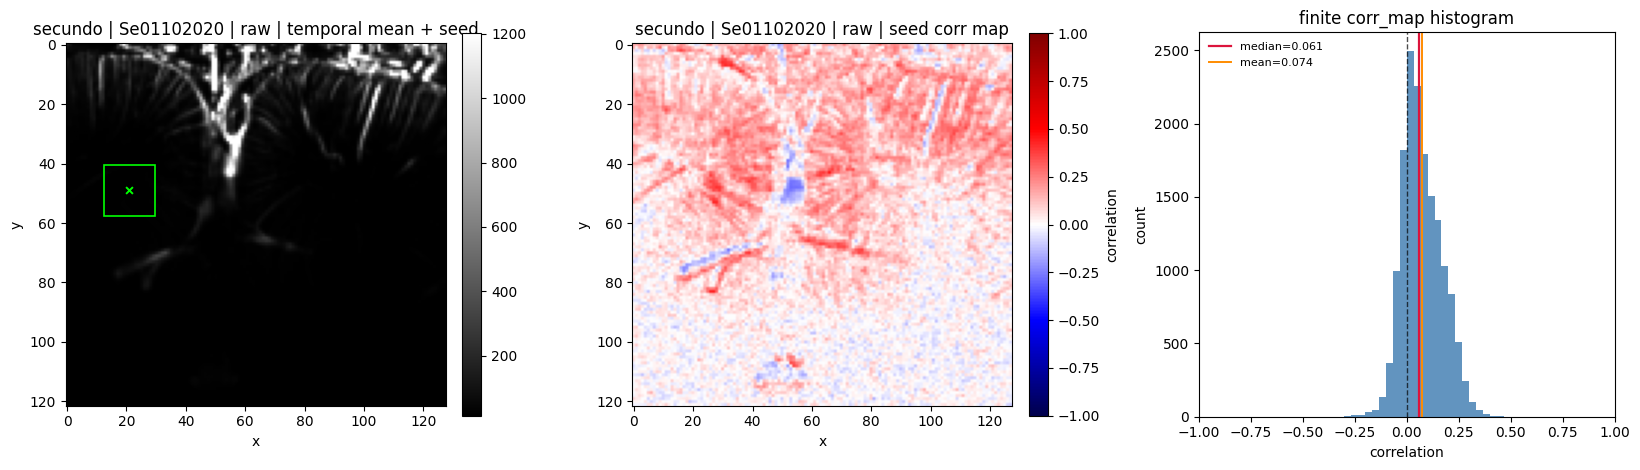

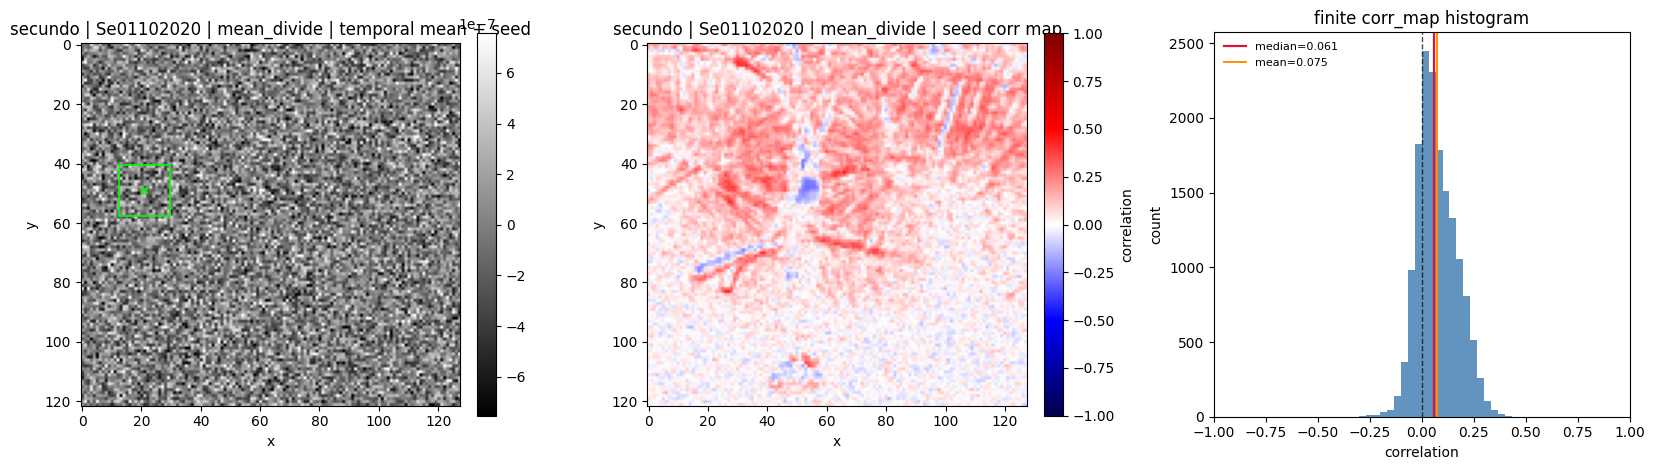

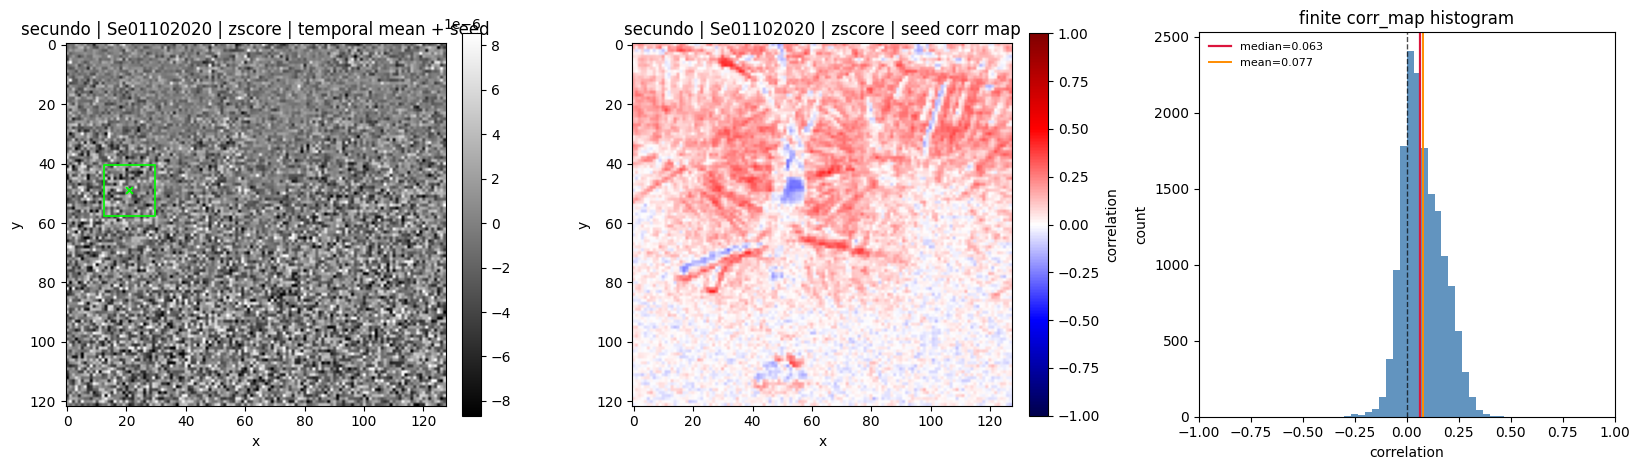

In [ ]:
analyzer = acf.CorrelationAnalyzer(
    deriv_root_path=deriv_root,
    eda_root_name_value=eda_root_name if "eda_root_name" in globals() else "eda",
    acf_qc_filename_value=(
        acf_qc_filename if "acf_qc_filename" in globals() else "acf_qc_summary.csv"
    ),
    frame_diff_robust_pctl=(
        fdiff_robust_pctl if "fdiff_robust_pctl" in globals() else (2.0, 98.0)
    ),
    spatial_eps_value=spatial_eps,
    spatial_min_valid_samples_value=spatial_min_valid_samples,
)

for subject in subjects:
    baseline_sessions = analyzer.list_baseline_sessions(subject)
    print(
        f"\n[{subject}] seed correlation per acquisition | sessions={len(baseline_sessions)}"
    )
    if len(baseline_sessions) == 0:
        continue

    out_root = acf.analysis_subject_root(subject, AUTOCORR_ROOT_SUBDIR) / SEED_ROOT_SUBDIR
    out_per = out_root / "per_session"
    out_per.mkdir(parents=True, exist_ok=True)

    n_saved = 0
    n_skipped = 0

    for s_idx, session in enumerate(baseline_sessions):
        session_id = str(session["session_id"])

        for mode in analysis_modes:
            summary_path = out_per / f"{subject}_{session_id}_{mode}_seed_corr_summary.csv"

            try:
                result = analyzer.compute_seed_correlation(
                    subject=subject,
                    session_id=session_id,
                    mode=mode,
                    seed_center_yx=SEED_CENTER,
                    seed_radius=SEED_PATCH_RADIUS,
                    eps=SEED_EPS,
                    min_samples=SEED_MIN_VALID_SAMPLES,
                )

                arr = result["frames"]
                corr_map = result["corr_map"]
                n_valid = result["n_valid"]
                seed_ts = result["seed_ts"]
                seed_mask = result["seed_mask"]
                summary_row = dict(result["summary"])

                finite = np.isfinite(corr_map)
                finite_corr_vals = corr_map[finite]
                n_finite = int(np.sum(finite))
                median_corr = float(np.median(finite_corr_vals)) if n_finite > 0 else np.nan

                mean_frame = np.nanmean(arr, axis=0)
                frame_vmin, frame_vmax = acf.robust_limits(mean_frame, pctl=(1.0, 99.0))

                fig, axes = plt.subplots(1, 3, figsize=(16.5, 4.8))

                im0 = axes[0].imshow(mean_frame, cmap="gray", vmin=frame_vmin, vmax=frame_vmax)
                axes[0].set_title(f"{subject} | {session_id} | {mode} | temporal mean + seed")
                axes[0].set_xlabel("x")
                axes[0].set_ylabel("y")
                fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

                y, x = int(SEED_CENTER[0]), int(SEED_CENTER[1])
                axes[0].scatter([x], [y], s=24, c="lime", marker="x", linewidths=1.4)
                if SEED_PATCH_RADIUS > 0:
                    r = int(SEED_PATCH_RADIUS)
                    y0 = max(0, y - r)
                    x0 = max(0, x - r)
                    y1 = min(arr.shape[1], y + r + 1)
                    x1 = min(arr.shape[2], x + r + 1)
                    rect = Rectangle(
                        (x0 - 0.5, y0 - 0.5),
                        float(x1 - x0),
                        float(y1 - y0),
                        fill=False,
                        edgecolor="lime",
                        linewidth=1.2,
                    )
                    axes[0].add_patch(rect)

                im1 = axes[1].imshow(corr_map, cmap="seismic", vmin=-1.0, vmax=1.0)
                axes[1].set_title(f"{subject} | {session_id} | {mode} | seed corr map")
                axes[1].set_xlabel("x")
                axes[1].set_ylabel("y")
                fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04, label="correlation")

                if n_finite > 0:
                    axes[2].hist(
                        finite_corr_vals,
                        bins=60,
                        range=(-1.0, 1.0),
                        color="steelblue",
                        alpha=0.85,
                        edgecolor="none",
                    )
                    mean_corr_hist = float(np.mean(finite_corr_vals))
                    axes[2].axvline(
                        0.0,
                        color="black",
                        linewidth=1.0,
                        linestyle="--",
                        alpha=0.7,
                    )
                    axes[2].axvline(
                        median_corr,
                        color="crimson",
                        linewidth=1.6,
                        label=f"median={median_corr:.3f}",
                    )
                    axes[2].axvline(
                        mean_corr_hist,
                        color="darkorange",
                        linewidth=1.4,
                        label=f"mean={mean_corr_hist:.3f}",
                    )
                    axes[2].legend(loc="upper left", fontsize=8, frameon=False)
                else:
                    axes[2].text(
                        0.5,
                        0.5,
                        "No finite corr values",
                        ha="center",
                        va="center",
                        transform=axes[2].transAxes,
                    )
                axes[2].set_xlim(-1.0, 1.0)
                axes[2].set_title("finite corr_map histogram")
                axes[2].set_xlabel("correlation")
                axes[2].set_ylabel("count")

                fig.tight_layout()
                fig_path = out_per / f"{subject}_{session_id}_{mode}_seed_corr.png"
                fig.savefig(fig_path, dpi=180)

                if subject == sample_subject and s_idx == sample_session_idx:
                    plt.show()
                else:
                    plt.close(fig)

                csv_path = out_per / f"{subject}_{session_id}_{mode}_seed_corr.csv"
                acf.save_value_map_csv(csv_path, corr_map, value_col="seed_corr")
                summary_row["map_csv_path"] = str(csv_path)
                pd.DataFrame([summary_row]).to_csv(summary_path, index=False)

                n_saved += 1
            except Exception as e:
                n_skipped += 1
                msg = str(e)
                print(f"  - skip seed corr {session_id} | {mode}: {msg}")
                skipped_row = acf.CorrelationAnalyzer._seed_summary(
                    subject=subject,
                    session_id=session_id,
                    mode=mode,
                    arr=None,
                    corr_map=None,
                    n_valid=None,
                    seed_ts=None,
                    seed_mask=None,
                    seed_center_yx=SEED_CENTER,
                    seed_radius=SEED_PATCH_RADIUS,
                    status="skipped",
                    reason=msg,
                )
                skipped_row["map_csv_path"] = ""
                pd.DataFrame([skipped_row]).to_csv(summary_path, index=False)

    print(
        f"Saved seed correlation outputs to: {out_per} | saved={n_saved} skipped={n_skipped}"
    )



In [ ]:



# -----------------------------
# helpers
# -----------------------------
def _radial_profile_df(corr_map, seed_center_yx, n_bins=40):
    H, W = corr_map.shape
    yy, xx = np.indices((H, W))
    dist = np.sqrt(
        (yy - float(seed_center_yx[0])) ** 2 + (xx - float(seed_center_yx[1])) ** 2
    )
    finite = np.isfinite(corr_map)

    n_bins = max(1, int(n_bins))
    dmax = float(np.max(dist))
    edges = np.linspace(0.0, dmax, n_bins + 1, dtype=np.float64)

    rows = []
    for b in range(n_bins):
        lo = float(edges[b])
        hi = float(edges[b + 1])
        if b == n_bins - 1:
            in_bin = (dist >= lo) & (dist <= hi) & finite
        else:
            in_bin = (dist >= lo) & (dist < hi) & finite

        vals = corr_map[in_bin]
        rows.append(
            {
                "distance_bin_idx": int(b),
                "distance_min_px": lo,
                "distance_max_px": hi,
                "distance_center_px": 0.5 * (lo + hi),
                "n_pixels": int(vals.size),
                "mean_corr": float(np.mean(vals)) if vals.size > 0 else np.nan,
                "median_corr": float(np.median(vals)) if vals.size > 0 else np.nan,
                "std_corr": float(np.std(vals)) if vals.size > 0 else np.nan,
            }
        )
    return pd.DataFrame(rows)


def _fmt(x):
    return "nan" if (not np.isfinite(x)) else f"{x:.4f}"


# -----------------------------
# load representative sample
# -----------------------------
if "analyzer" not in globals():
    analyzer = acf.CorrelationAnalyzer(
        deriv_root_path=deriv_root,
        eda_root_name_value=eda_root_name if "eda_root_name" in globals() else "eda",
        acf_qc_filename_value=(
            acf_qc_filename if "acf_qc_filename" in globals() else "acf_qc_summary.csv"
        ),
        frame_diff_robust_pctl=(
            fdiff_robust_pctl if "fdiff_robust_pctl" in globals() else (2.0, 98.0)
        ),
        spatial_eps_value=spatial_eps,
        spatial_min_valid_samples_value=spatial_min_valid_samples,
    )

baseline_sessions = analyzer.list_baseline_sessions(sample_subject)
if len(baseline_sessions) == 0:
    raise RuntimeError(f"No baseline sessions found for subject={sample_subject!r}")

if data_mode not in analysis_modes:
    raise ValueError(f"data_mode={data_mode!r} not in analysis_modes={analysis_modes}")

s_idx = int(np.clip(int(sample_session_idx), 0, len(baseline_sessions) - 1))
session_id = str(baseline_sessions[s_idx]["session_id"])

result = analyzer.compute_seed_correlation(
    subject=sample_subject,
    session_id=session_id,
    mode=data_mode,
    seed_center_yx=SEED_CENTER,
    seed_radius=SEED_PATCH_RADIUS,
    eps=SEED_EPS,
    min_samples=SEED_MIN_VALID_SAMPLES,
)
arr = result["frames"]
corr_map = result["corr_map"]
n_valid = result["n_valid"]
seed_ts = result["seed_ts"]
seed_mask = result["seed_mask"]

out_per = acf.analysis_subject_root(sample_subject, AUTOCORR_ROOT_SUBDIR) / SEED_ROOT_SUBDIR / "per_session"
out_per.mkdir(parents=True, exist_ok=True)

# -----------------------------
# radial profile
# -----------------------------
radial_df = _radial_profile_df(corr_map, seed_center_yx=SEED_CENTER, n_bins=RADIAL_N_BINS)
radial_csv_path = out_per / "radial_profile.csv"
radial_png_path = out_per / "radial_profile.png"
radial_df.to_csv(radial_csv_path, index=False)

fig_r, ax_r = plt.subplots(figsize=(6.8, 4.2))
valid_rows = radial_df["n_pixels"] > 0
if np.any(valid_rows):
    ax_r.plot(
        radial_df.loc[valid_rows, "distance_center_px"].to_numpy(),
        radial_df.loc[valid_rows, "mean_corr"].to_numpy(),
        color="steelblue",
        linewidth=2.0,
        marker="o",
        markersize=3.5,
    )
else:
    ax_r.text(0.5, 0.5, "No finite corr values", ha="center", va="center", transform=ax_r.transAxes)

ax_r.axhline(0.0, color="black", linewidth=1.0, linestyle="--", alpha=0.7)
ax_r.set_title(f"{sample_subject} | {session_id} | {data_mode} | radial profile")
ax_r.set_xlabel("distance to seed center (pixels)")
ax_r.set_ylabel("mean seed correlation")
ax_r.grid(alpha=0.25, linewidth=0.6)
fig_r.tight_layout()
fig_r.savefig(radial_png_path, dpi=180)
plt.show()
plt.close(fig_r)

# -----------------------------
# shuffle control (same min_samples logic via safe_temporal_corr_map)
# -----------------------------
rng = np.random.default_rng(int(SHUFFLE_SEED))
if SHUFFLE_KIND == "circular_shift":
    shift = int(rng.integers(1, arr.shape[0])) if arr.shape[0] > 1 else 0
    seed_ts_shuf = np.roll(seed_ts, shift)
    shuffle_meta = f"kind=circular_shift shift={shift}"
elif SHUFFLE_KIND == "time_shuffle":
    seed_ts_shuf = rng.permutation(seed_ts)
    shuffle_meta = "kind=time_shuffle"
else:
    raise ValueError(f"Unsupported SHUFFLE_KIND={SHUFFLE_KIND!r}")

seed_3d_shuf = np.broadcast_to(seed_ts_shuf.reshape(arr.shape[0], 1, 1), arr.shape)
corr_map_shuf, n_valid_shuf = acf.safe_temporal_corr_map(
    arr,
    seed_3d_shuf,
    eps=SEED_EPS,
    min_samples=SEED_MIN_VALID_SAMPLES,
)

# shuffled map png
map_shuf_png_path = out_per / "seed_corr_map_shuffled.png"
fig_m, ax_m = plt.subplots(figsize=(6.0, 4.8))
im_m = ax_m.imshow(corr_map_shuf, cmap="seismic", vmin=-1.0, vmax=1.0)
ax_m.scatter([int(SEED_CENTER[1])], [int(SEED_CENTER[0])], s=24, c="lime", marker="x", linewidths=1.4)
ax_m.set_title(f"{sample_subject} | {session_id} | {data_mode} | shuffled seed corr map")
ax_m.set_xlabel("x")
ax_m.set_ylabel("y")
fig_m.colorbar(im_m, ax=ax_m, fraction=0.046, pad=0.04, label="correlation")
fig_m.tight_layout()
fig_m.savefig(map_shuf_png_path, dpi=180)
plt.show()
plt.close(fig_m)

# shuffled histogram png
hist_shuf_png_path = out_per / "finite_corr_hist_shuffled.png"
finite_shuf = np.isfinite(corr_map_shuf)
finite_shuf_vals = corr_map_shuf[finite_shuf]
shuf_mean = float(np.mean(finite_shuf_vals)) if finite_shuf_vals.size > 0 else np.nan
shuf_median = float(np.median(finite_shuf_vals)) if finite_shuf_vals.size > 0 else np.nan

fig_h, ax_h = plt.subplots(figsize=(6.0, 4.2))
if finite_shuf_vals.size > 0:
    ax_h.hist(
        finite_shuf_vals,
        bins=60,
        range=(-1.0, 1.0),
        color="slategray",
        alpha=0.9,
        edgecolor="none",
    )
    ax_h.axvline(0.0, color="black", linewidth=1.0, linestyle="--", alpha=0.7)
    ax_h.axvline(shuf_median, color="crimson", linewidth=1.6, label=f"median={shuf_median:.3f}")
    ax_h.axvline(shuf_mean, color="darkorange", linewidth=1.4, label=f"mean={shuf_mean:.3f}")
    ax_h.legend(loc="upper left", fontsize=8, frameon=False)
else:
    ax_h.text(0.5, 0.5, "No finite corr values", ha="center", va="center", transform=ax_h.transAxes)
ax_h.set_xlim(-1.0, 1.0)
ax_h.set_title("finite shuffled corr_map histogram")
ax_h.set_xlabel("correlation")
ax_h.set_ylabel("count")
fig_h.tight_layout()
fig_h.savefig(hist_shuf_png_path, dpi=180)
plt.show()
plt.close(fig_h)

# -----------------------------
# summary printout requested
# -----------------------------
finite = np.isfinite(corr_map)
finite_vals = corr_map[finite]
seed_corr_vals = corr_map[seed_mask & finite]

seed_min = float(np.min(seed_corr_vals)) if seed_corr_vals.size > 0 else np.nan
seed_mean = float(np.mean(seed_corr_vals)) if seed_corr_vals.size > 0 else np.nan
seed_max = float(np.max(seed_corr_vals)) if seed_corr_vals.size > 0 else np.nan

whole_mean = float(np.mean(finite_vals)) if finite_vals.size > 0 else np.nan
whole_median = float(np.median(finite_vals)) if finite_vals.size > 0 else np.nan

print(
    f"[seed diagnostics] subject={sample_subject} session={session_id} mode={data_mode} | {shuffle_meta}"
)
print(
    "  seed-mask corr min/mean/max: "
    f"{_fmt(seed_min)} / {_fmt(seed_mean)} / {_fmt(seed_max)}"
)
print(
    "  whole-map mean/median: "
    f"{_fmt(whole_mean)} / {_fmt(whole_median)}"
)
print(
    "  shuffled mean/median: "
    f"{_fmt(shuf_mean)} / {_fmt(shuf_median)}"
)
print("  saved:")
print(f"    {radial_csv_path}")
print(f"    {radial_png_path}")
print(f"    {map_shuf_png_path}")
print(f"    {hist_shuf_png_path}")


Loaded 34 baseline sessions


NameError: name 'sample_mode' is not defined

### 3D seed-based maps

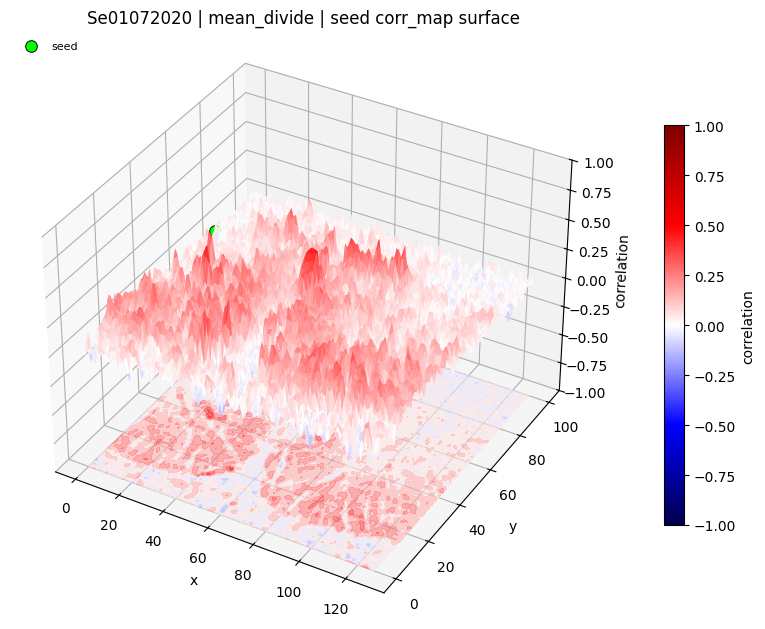

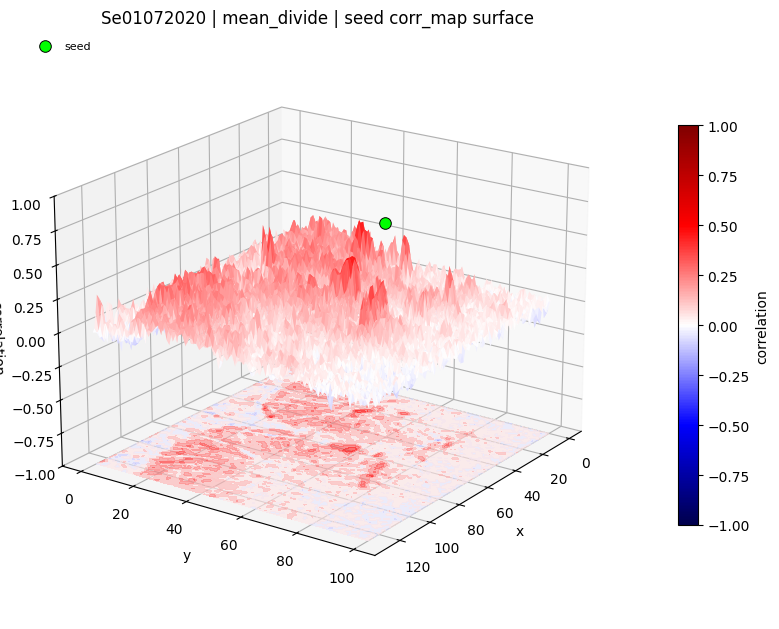

Saved: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\eda\autocorr_psd\seed_corr\per_session\seed_corr_surface.png
Saved: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\eda\autocorr_psd\seed_corr\per_session\seed_corr_surface_altview.png


In [ ]:

# from mpl_toolkits.mplot3d import Axes3D 


def plot_seed_corr_surface(
    corr_map,
    seed_mask=None,
    seed_center_yx=None,
    out_dir=".",
    session_label="session",
    condition_label="condition",
    zlim=(-1.0, 1.0),
    elev=35,
    azim=-60,
    save_altview=True,
    alt_elev=20,
    alt_azim=35,
    dpi=180,
):
    corr = np.asarray(corr_map, dtype=np.float64)
    if corr.ndim != 2:
        raise ValueError(f"Expected 2D corr_map, got shape={corr.shape}")

    H, W = corr.shape
    X, Y = np.meshgrid(np.arange(W), np.arange(H))
    Z = np.ma.masked_invalid(corr)

    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    if seed_mask is not None:
        seed_mask = np.asarray(seed_mask, dtype=bool)
        if seed_mask.shape != corr.shape:
            raise ValueError(f"seed_mask shape {seed_mask.shape} != corr_map shape {corr.shape}")

    if seed_center_yx is None:
        seed_center_yx = (H // 2, W // 2)
    seed_y = int(np.clip(seed_center_yx[0], 0, H - 1))
    seed_x = int(np.clip(seed_center_yx[1], 0, W - 1))

    # 1) seed marker z-height update
    if seed_mask is not None and np.any(seed_mask):
        try:
            z_seed = float(np.nanmax(corr[seed_mask]))
        except ValueError:
            z_seed = float(corr[seed_y, seed_x]) if np.isfinite(corr[seed_y, seed_x]) else np.nan
    else:
        z_seed = float(corr[seed_y, seed_x]) if np.isfinite(corr[seed_y, seed_x]) else np.nan

    if not np.isfinite(z_seed):
        finite_vals = corr[np.isfinite(corr)]
        z_seed = float(np.nanmax(finite_vals)) if finite_vals.size > 0 else 0.0

    zmin, zmax = float(zlim[0]), float(zlim[1])  # keep [-1, 1]

    def _draw(view_elev, view_azim, filename):
        fig = plt.figure(figsize=(8.6, 6.4))
        ax = fig.add_subplot(111, projection="3d")

        # main 3D surface
        ax.plot_surface(
            X, Y, Z,
            cmap="seismic",
            vmin=-1.0, vmax=1.0,
            linewidth=0,
            antialiased=True,
            rstride=1, cstride=1,
        )

        # 2) base-plane projection at z = -1
        ax.contourf(
            X, Y, Z,
            zdir="z",
            offset=-1.0,
            levels=np.linspace(-1.0, 1.0, 21),
            cmap="seismic",
            vmin=-1.0,
            vmax=1.0,
            alpha=0.6,
        )

        # seed point
        ax.scatter(
            seed_x, seed_y, z_seed,
            s=70, c="lime", edgecolors="black", linewidths=0.7,
            depthshade=False, label="seed",
        )

        sm = matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=-1.0, vmax=1.0),
            cmap="seismic",
        )
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.68, pad=0.08)
        cbar.set_label("correlation")

        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("correlation")
        ax.set_zlim(zmin, zmax)  # keep [-1, 1]
        ax.view_init(elev=view_elev, azim=view_azim)
        ax.set_title(f"{session_label} | {condition_label} | seed corr_map surface")
        ax.legend(loc="upper left", frameon=False, fontsize=8)

        fig.tight_layout()
        out_path = out_dir / filename
        fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
        plt.show()
        plt.close(fig)
        return out_path

    p_main = _draw(elev, azim, "seed_corr_surface.png")
    p_alt = None
    if save_altview:
        p_alt = _draw(alt_elev, alt_azim, "seed_corr_surface_altview.png")

    print(f"Saved: {p_main}")
    if p_alt is not None:
        print(f"Saved: {p_alt}")


# usage
_surface_out_dir = out_per if "out_per" in globals() else Path.cwd()
_session_label = str(session_id) if "session_id" in globals() else "session"
_condition_label = str(mode) if "mode" in globals() else "condition"
_seed_center = (int(SEED_CENTER[0]), int(SEED_CENTER[1])) if "SEED_CENTER" in globals() else None

plot_seed_corr_surface(
    corr_map=corr_map,
    seed_mask=seed_mask if "seed_mask" in globals() else None,
    seed_center_yx=_seed_center,
    out_dir=_surface_out_dir,
    session_label=_session_label,
    condition_label=_condition_label,
    zlim=(-1.0, 1.0),
    elev=35,
    azim=-60,
    save_altview=True,
    alt_elev=20,
    alt_azim=35,
)


### PSDs


across acquisitions

Loaded 34 baseline sessions
\n[secundo] PSD per/across acquisitions | sessions=34


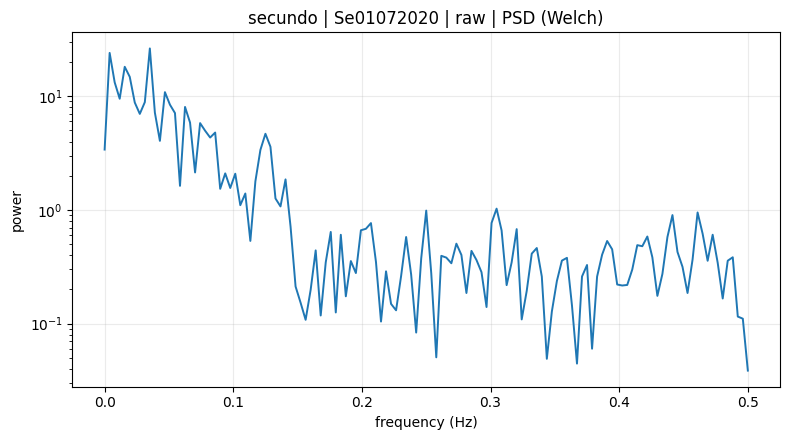

  - skip PSD Se27072020 | raw: failed preprocessing QC: too_short_or_nan_only
  - skip PSD Se31012020 | raw: failed preprocessing QC: too_short_or_nan_only


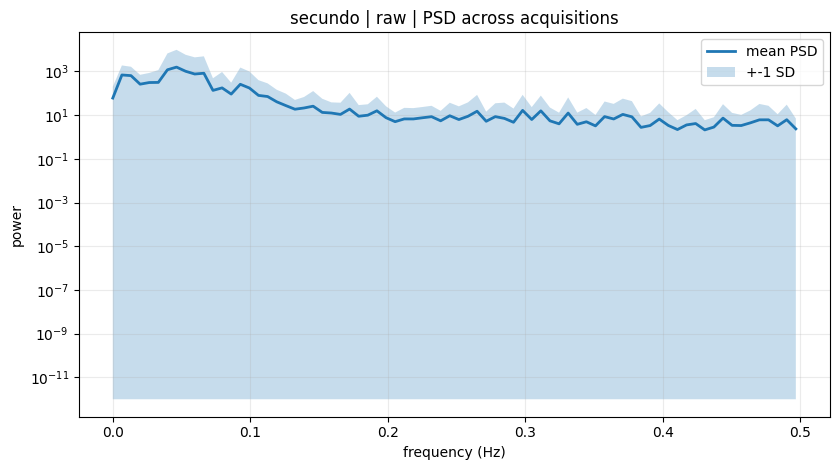

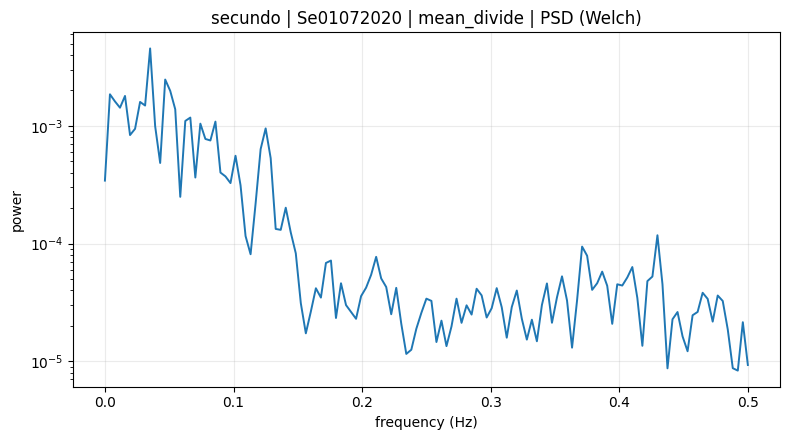

  - skip PSD Se27072020 | mean_divide: failed preprocessing QC: too_short_or_nan_only
  - skip PSD Se31012020 | mean_divide: failed preprocessing QC: too_short_or_nan_only


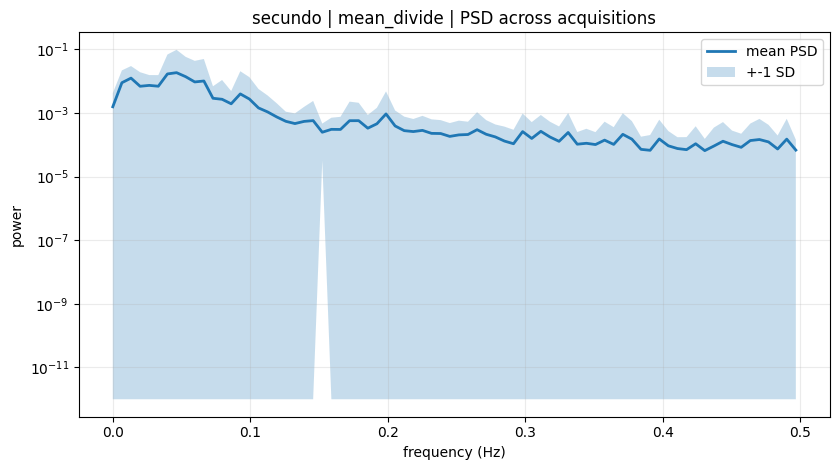

Saved PSD outputs to: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\eda\autocorr_psd\psd
Loaded 13 baseline sessions
\n[gus] PSD per/across acquisitions | sessions=13
Saved PSD outputs to: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus\eda\autocorr_psd\psd


In [ ]:
if "_ensure_acf_configured" in globals():
    _ensure_acf_configured()
else:
    acf.configure(deriv_root_path=deriv_root)

for subject in subjects:
    baseline_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_dir))
    print(
        f"\\n[{subject}] PSD per/across acquisitions | sessions={len(baseline_sessions)}"
    )
    if len(baseline_sessions) == 0:
        continue

    if "_load_acf_qc_map_for_subject" in globals():
        qc_map = _load_acf_qc_map_for_subject(subject)
    else:
        qc_map = {}

    out_root = acf.analysis_subject_root(subject, AUTOCORR_ROOT_SUBDIR) / "psd"
    out_per = out_root / "per_session"
    out_across = out_root / "across_sessions"
    out_per.mkdir(parents=True, exist_ok=True)
    out_across.mkdir(parents=True, exist_ok=True)

    for mode in GLOBAL_SIGNAL_MODES:
        freq_list = []
        power_list = []
        session_ids_used = []
        skipped = []

        for s_idx, session in enumerate(baseline_sessions):
            session_id = session["session_id"]

            if "_acf_qc_allows_session" in globals():
                allow_session, qc_reason = _acf_qc_allows_session(
                    qc_map,
                    session_id,
                    mode,
                    require_qc=ACF_REQUIRE_QC,
                )
            else:
                allow_session, qc_reason = True, ""

            if not allow_session:
                msg = f"failed preprocessing QC: {qc_reason}"
                print(f"  - skip PSD {session_id} | {mode}: {msg}")
                skipped.append((session_id, msg))
                pd.DataFrame(
                    [
                        {
                            "subject": subject,
                            "session_id": session_id,
                            "mode": mode,
                            "status": "skipped_qc",
                            "reason": msg,
                        }
                    ]
                ).to_csv(
                    out_per / f"{subject}_{session_id}_{mode}_psd.csv", index=False
                )
                continue

            try:
                arr, metadata, _ = acf.load_saved_session_bundle(
                    deriv_root, subject, session_id, mode
                )
                x = _session_global_signal(arr)
                if x is None:
                    raise ValueError(
                        "invalid global signal (too short / NaN-only / near-constant)"
                    )

                fs = DEFAULT_FS_HZ
                if "source_fps" in metadata:
                    try:
                        fs_meta = float(np.asarray(metadata["source_fps"]).item())
                        if np.isfinite(fs_meta) and fs_meta > 0:
                            fs = fs_meta
                    except Exception:
                        pass

                nperseg = int(min(PSD_NPERSEG, x.size))
                if nperseg < 2:
                    raise ValueError("insufficient samples for Welch PSD")

                f, pxx = signal.welch(x, fs=float(fs), nperseg=nperseg)
                if (f.size == 0) or (pxx.size == 0):
                    raise ValueError("empty PSD result")

                eps = 1e-12
                fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
                ax.semilogy(f, np.maximum(pxx, eps), lw=1.4)
                ax.set_title(f"{subject} | {session_id} | {mode} | PSD (Welch)")
                ax.set_xlabel("frequency (Hz)")
                ax.set_ylabel("power")
                ax.grid(alpha=0.25)
                fig.tight_layout()
                fig.savefig(out_per / f"{subject}_{session_id}_{mode}_psd.png", dpi=180)

                if subject == sample_subject and s_idx == sample_session_idx:
                    plt.show()
                else:
                    plt.close(fig)

                pd.DataFrame(
                    {
                        "subject": subject,
                        "session_id": session_id,
                        "mode": mode,
                        "freq_hz": f.astype(np.float64),
                        "psd_power": pxx.astype(np.float64),
                        "source_fps": float(fs),
                        "n_frames": int(arr.shape[0]),
                        "n_signal_samples": int(x.size),
                        "nperseg": int(nperseg),
                        "status": "ok",
                    }
                ).to_csv(
                    out_per / f"{subject}_{session_id}_{mode}_psd.csv", index=False
                )

                freq_list.append(f.astype(np.float64))
                power_list.append(pxx.astype(np.float64))
                session_ids_used.append(session_id)
            except Exception as e:
                msg = str(e)
                print(f"  - skip PSD {session_id} | {mode}: {msg}")
                skipped.append((session_id, msg))
                pd.DataFrame(
                    [
                        {
                            "subject": subject,
                            "session_id": session_id,
                            "mode": mode,
                            "status": "skipped",
                            "reason": msg,
                        }
                    ]
                ).to_csv(
                    out_per / f"{subject}_{session_id}_{mode}_psd.csv", index=False
                )

        if len(freq_list) == 0:
            pd.DataFrame(
                [
                    {
                        "subject": subject,
                        "mode": mode,
                        "status": "no_valid_sessions",
                        "n_sessions_total": int(len(baseline_sessions)),
                        "n_sessions_used": 0,
                        "n_sessions_skipped": int(len(skipped)),
                    }
                ]
            ).to_csv(
                out_across / f"{subject}_{mode}_psd_across_summary.csv", index=False
            )
            continue

        f_min = max(float(np.min(f)) for f in freq_list)
        f_max = min(float(np.max(f)) for f in freq_list)
        if not np.isfinite(f_min) or not np.isfinite(f_max) or (f_max <= f_min):
            pd.DataFrame(
                [
                    {
                        "subject": subject,
                        "mode": mode,
                        "status": "no_common_frequency_range",
                        "n_sessions_total": int(len(baseline_sessions)),
                        "n_sessions_used": int(len(freq_list)),
                        "n_sessions_skipped": int(len(skipped)),
                        "f_min_intersection": f_min,
                        "f_max_intersection": f_max,
                    }
                ]
            ).to_csv(
                out_across / f"{subject}_{mode}_psd_across_summary.csv", index=False
            )
            continue

        n_common = int(min(len(f) for f in freq_list))
        n_common = max(8, n_common)
        f_common = np.linspace(f_min, f_max, num=n_common, dtype=np.float64)

        P = []
        for f, p in zip(freq_list, power_list, strict = False):
            P.append(np.interp(f_common, f, p))
        P = np.stack(P, axis=0)

        p_mean = np.nanmean(P, axis=0)
        p_std = np.nanstd(P, axis=0)

        eps = 1e-12
        fig, ax = plt.subplots(1, 1, figsize=(8.5, 4.8))
        ax.semilogy(f_common, np.maximum(p_mean, eps), lw=2.0, label="mean PSD")
        ax.fill_between(
            f_common,
            np.maximum(p_mean - p_std, eps),
            np.maximum(p_mean + p_std, eps),
            alpha=0.25,
            label="+-1 SD",
        )
        ax.set_title(f"{subject} | {mode} | PSD across acquisitions")
        ax.set_xlabel("frequency (Hz)")
        ax.set_ylabel("power")
        ax.grid(alpha=0.25)
        ax.legend(loc="best")
        fig.tight_layout()
        fig.savefig(out_across / f"{subject}_{mode}_psd_across.png", dpi=180)

        if subject == sample_subject:
            plt.show()
        else:
            plt.close(fig)

        pd.DataFrame(
            {
                "subject": subject,
                "mode": mode,
                "freq_hz": f_common,
                "psd_mean": p_mean,
                "psd_std": p_std,
                "n_sessions_used": int(P.shape[0]),
            }
        ).to_csv(out_across / f"{subject}_{mode}_psd_across_curve.csv", index=False)

        pd.DataFrame(
            [
                {
                    "subject": subject,
                    "mode": mode,
                    "status": "ok",
                    "n_sessions_total": int(len(baseline_sessions)),
                    "n_sessions_used": int(P.shape[0]),
                    "n_sessions_skipped": int(len(skipped)),
                    "f_min_intersection": float(f_min),
                    "f_max_intersection": float(f_max),
                    "used_session_ids": "|".join(str(s) for s in session_ids_used),
                }
            ]
        ).to_csv(out_across / f"{subject}_{mode}_psd_across_summary.csv", index=False)

    print(f"Saved PSD outputs to: {out_root}")
